# Implementation of GANs using PyTorch (Generative Adversarial Networks)

Implementation of the original ['Generative Adversarial Networks'](https://arxiv.org/abs/1406.2661) paper in PyTorch with the Celeba Dataset from scratch.

Generative Adversarial Networks (GANs) involve training two neural networks in competition with each other:
1. **Generator**: This network generates fake images from random noise, aiming to create images indistinguishable from real ones.
2. **Critic**: This network differentiates between real and fake images, attempting to correctly classify images as real or fake.

The training process involves a game-like scenario where:
- The generator tries to produce realistic fake images to fool the critic.
- The critic improves its ability to distinguish between real and fake images.

Over time, as long as neither network becomes too dominant, they both improve, with the generator eventually becoming proficient at creating highly realistic images.

> Note: This implementation covers the GAN architecture and training process with only $50$ epochs. For better results, you can train the model for more epochs.

In [1]:
!nvidia-smi

Wed Jul 10 10:22:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/MyDrive')

import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import gdown, zipfile

def show(tensor, num=25, name=''):
    data = tensor.detach().cpu()
    grid = make_grid(data[:num], nrow=5).permute(1, 2, 0)

    plt.imshow(grid.clip(0, 1))

## hyperparameters and general parameters
n_epochs = 50 # only 50 so I save on compute resources
batch_size = 128
lr = 1e-4
z_dim=200
device='cuda'

cur_step=0
crit_cycles=5
gen_losses = []
crit_losses = []
show_step = 35
save_step = 35

Mounted at /MyDrive


# generator model

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=64, d_dim=16):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0), ## 4x4 (ch: 200, 512)
            nn.BatchNorm2d(d_dim*32),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), ## 8x8 (ch: 512, 256)
            nn.BatchNorm2d(d_dim*16),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), ## 16x16 (ch: 256, 128)
            nn.BatchNorm2d(d_dim*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), ## 32x32 (ch: 128, 64)
            nn.BatchNorm2d(d_dim*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), ## 64x64 (ch: 64, 32)
            nn.BatchNorm2d(d_dim*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), ## 128x128 (ch: 32, 3)
            nn.Tanh() ### porduce result in the range from -1 to 1
        )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1 , 1) # 128 x 200 x 1 x 1
        return self.gen(x)

def gen_noise(num, z_dim, device='cuda'):
    return torch.randn(num, z_dim, device=device) # 128 x 200

# critic model

In [4]:
class Critic(nn.Module):
    def __init__(self, d_dim=16):
        super(Critic, self).__init__()

        self.crit = nn.Sequential(
            # Conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
            ## New width and height: (n + 2 * pad - ks) // stride + 1
            nn.Conv2d(3, d_dim, 4, 2, 1), # (n + 2 * pad - ks) // stride + 1 = (128 + 2 * 1 - 4) // 2 + 1 = 64 x 64 (ch: 3, 16)
            nn.InstanceNorm2d(d_dim),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), ## 32 x 32 (ch: 16, 32)
            nn.InstanceNorm2d(d_dim * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), ## 16 x 16 (ch: 32, 64)
            nn.InstanceNorm2d(d_dim * 4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1), ## 8 x 8 (ch: 64, 128)
            nn.InstanceNorm2d(d_dim * 8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), ## 4 x 4 (ch: 128, 256)
            nn.InstanceNorm2d(d_dim * 16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim*16, 1, 4, 1, 0), # (n + 2 * pad - ks) // stride + 1 = (4 + 2 * 0 - 4) // 1 + 1 = 1 x 1 (ch: 256, 1)
        )

    def forward(self, image):
        # image: 128 x 3 x 128 x 128
        crit_pred = self.crit(image) # 128 x 1 x 1 x 1
        return crit_pred.view(len(crit_pred), -1)

### optional, init your weights in different ways

In [5]:
# optional, init your weights in different ways
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# load dataset

In [6]:
import gdown
import zipfile
import os

# URL for direct download
url = 'https://drive.google.com/uc?export=download&id=1BU7XlskUYUb34X0Ag_tiMpXq0rCmfGqs'
path = 'data/celeba'
download_path = f'{path}/img_align_celeba.zip'

if not os.path.exists(path):
    os.makedirs(path)

# Download the file
gdown.download(url, download_path, quiet=False)

# Extract the ZIP file
with zipfile.ZipFile(download_path, 'r') as ziphandler:
    ziphandler.extractall(path)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1BU7XlskUYUb34X0Ag_tiMpXq0rCmfGqs
From (redirected): https://drive.google.com/uc?export=download&id=1BU7XlskUYUb34X0Ag_tiMpXq0rCmfGqs&confirm=t&uuid=bcae899f-138a-4a53-bef9-64fb717fa0e4
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.50G/1.50G [00:18<00:00, 79.8MB/s]


# Dataset, DataLoader, declare gen, crit, test dataset

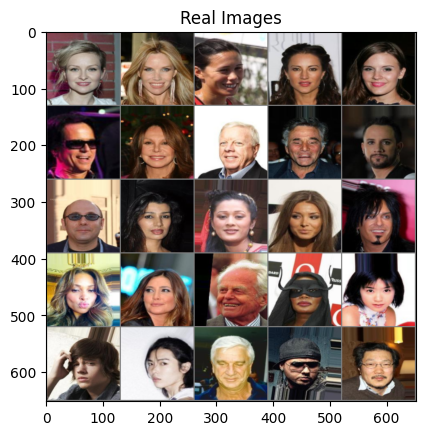

In [7]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, path, size=128, lim=10000):
        self.transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        items, labels = [], []

        for data in os.listdir(path)[:lim]:
            item = os.path.join(path, data)
            items.append(item)
            labels.append(data)

        self.items = items
        self.labels = labels

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        data = PIL.Image.open(self.items[idx]).convert('RGB')
        data = self.transform(data)
        return data, self.labels[idx]

def show(tensor, num=25, name=''):
    data = tensor.detach().cpu()
    grid = make_grid(data[:num], nrow=5).permute(1, 2, 0)
    grid = (grid + 1) / 2  # Rescale from [-1, 1] to [0, 1]
    plt.imshow(grid.clip(0, 1))
    plt.title(name)
    plt.show()

# Dataset
data_path = './data/celeba/img_align_celeba'
ds = CustomDataset(data_path, size=128, lim=10000)

# DataLoader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

# Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.9))

x, y = next(iter(dataloader))
show(x, name='Real Images')

# gradient penalty calculation

In [8]:
def get_gp(real, fake, crit, alpha, gamma=10):
    mix_images = real * alpha + fake * (1 - alpha) # 128 x 3 x 128 x 128
    mix_scores = crit(mix_images) # 128 x 1

    gradient = torch.autograd.grad(
        inputs = mix_images,
        outputs = mix_scores,
        grad_outputs=torch.ones_like(mix_scores),
        retain_graph=True,
        create_graph=True,
    )[0] # 128 x 3 x  128 x 128

    gradient = gradient.view(len(gradient), -1) # 128 x 49152
    gradient_norm = gradient.norm(2, dim=1)
    gp = gamma * ((gradient_norm - 1)**2).mean()

    return gp

# Save and load checkpoints

In [9]:
root_path = './data/'

def save_checkpoint(epoch, name):
    torch.save({
        'epoch': epoch,
        'model_state_dict': gen.state_dict(),
        'optimizaer_state_dict': gen_opt.state_dict()
    }, f"{root_path}G-{name}.pkl")

    torch.save({
        'epoch': epoch,
        'model_state_dict': crit.state_dict(),
        'optimizaer_state_dict': crit_opt.state_dict()
    }, f"{root_path}C-{name}.pkl")

    print("Saved checkpoint")

def load_checkpoint(name):
    checkpoint = torch.load(f"{root_path}G-{name}.pkl")
    gen.load_state_dict(checkpoint['model_state_dict'])
    gen_opt.load_state_dict(checkpoint['optimizaer_state_dict'])

    checkpoint = torch.load(f"{root_path}C-{name}.pkl")
    crit.load_state_dict(checkpoint['model_state_dict'])
    crit_opt.load_state_dict(checkpoint['optimizaer_state_dict'])

    print("Loaded checkpoint")

# Training Loop

In [ ]:
# Ensure save_checkpoint is called with the correct arguments
root_path = './data/'

def save_checkpoint(epoch, name):
    torch.save({
        'epoch': epoch,
        'model_state_dict': gen.state_dict(),
        'optimizer_state_dict': gen_opt.state_dict()
    }, f"{root_path}G-{name}.pkl")

    torch.save({
        'epoch': epoch,
        'model_state_dict': crit.state_dict(),
        'optimizer_state_dict': crit_opt.state_dict()
    }, f"{root_path}C-{name}.pkl")

    print("Saved checkpoint")

def load_checkpoint(name):
    checkpoint = torch.load(f"{root_path}G-{name}.pkl")
    gen.load_state_dict(checkpoint['model_state_dict'])
    gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    checkpoint = torch.load(f"{root_path}C-{name}.pkl")
    crit.load_state_dict(checkpoint['model_state_dict'])
    crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Loaded checkpoint")

cur_step = 0

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_bs = len(real) # 128
        real = real.to(device)

        ### CRITIC
        mean_crit_loss = 0
        for _ in range(crit_cycles):
            crit_opt.zero_grad()

            noise = gen_noise(cur_bs, z_dim)
            fake = gen(noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            alpha = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True) # 128 x 1 x 1 x 1
            gp = get_gp(real, fake.detach(), crit, alpha)

            crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

            mean_crit_loss += crit_loss.item() / crit_cycles

            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        crit_losses += [mean_crit_loss]

        ### GENERATOR
        gen_opt.zero_grad()
        noise = gen_noise(cur_bs, z_dim)
        fake = gen(noise)
        crit_fake_pred = crit(fake)

        gen_loss = -crit_fake_pred.mean()
        gen_loss.backward()
        gen_opt.step()

        gen_losses += [gen_loss.item()]

        ### Stats
        if cur_step % save_step == 0 and cur_step > 0:
            print("Saving checkpoint: ", cur_step, save_step)
            save_checkpoint(epoch, "latest")

        if cur_step % show_step == 0 and cur_step > 0:
            show(fake, name='fake')
            show(real, name='real')

            gen_mean = sum(gen_losses[-show_step:]) / show_step
            crit_mean = sum(crit_losses[-show_step:]) / show_step
            print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

            plt.plot(
                range(len(gen_losses)),
                torch.Tensor(gen_losses),
                label="Generator Loss"
            )

            plt.plot(
                range(len(crit_losses)),
                torch.Tensor(crit_losses),
                label="Critic Loss"
            )

            plt.ylim(-1000, 1000)
            plt.legend()
            plt.show()

        cur_step += 1

# Generate new faces

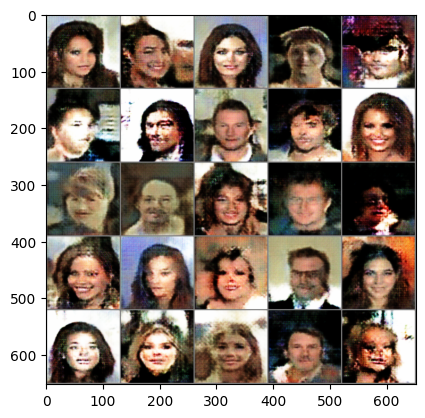

In [11]:
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

# MORPHING, interpolation between points in latent space

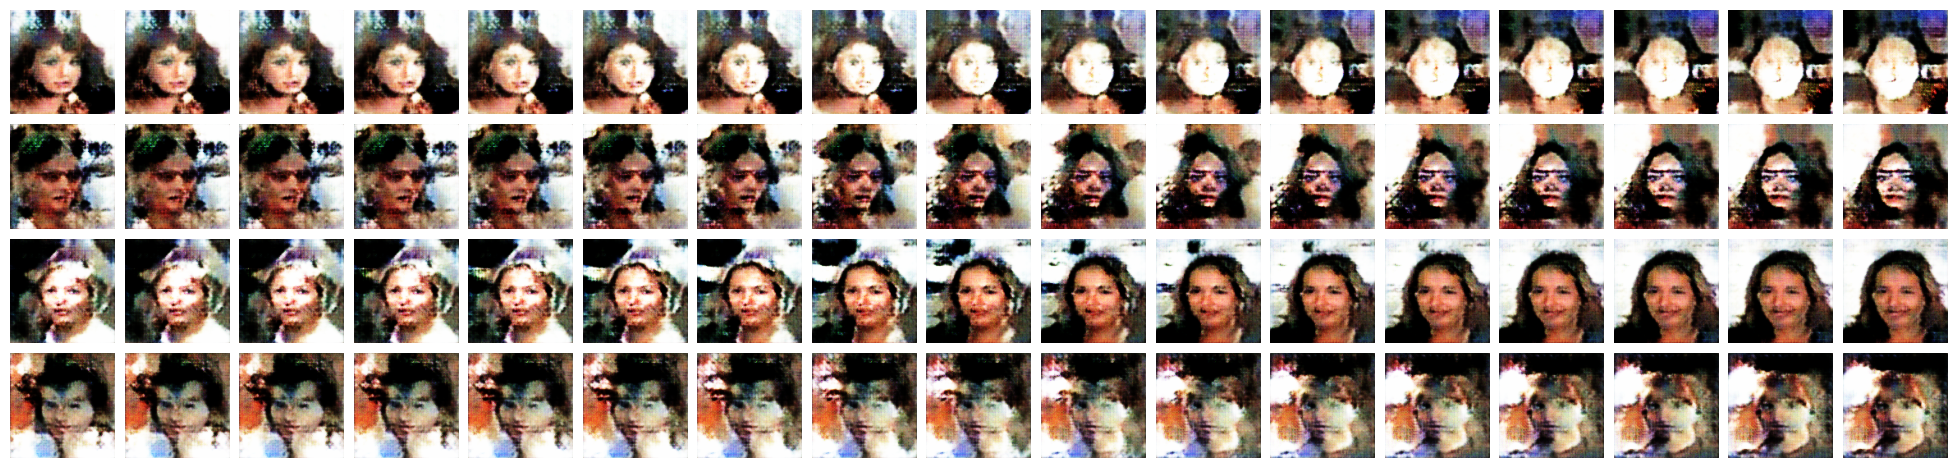

In [12]:
from mpl_toolkits.axes_grid1 import ImageGrid

gen_set = []
z_shape = [1, 200, 1, 1]
rows = 4
steps = 17

for i in range(rows):
    z1, z2 = torch.randn(z_shape), torch.randn(z_shape)
    for alpha in  np.linspace(0, 1, steps):
        z=alpha * z1 + (1 - alpha) * z2
        res = gen(z.cuda())[0]
        gen_set.append(res)

fig = plt.figure(figsize = (25, 11))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, steps),axes_pad=0.1)

for ax, img in zip(grid, gen_set):
    ax.axis('off')
    res = img.cpu().detach().permute(1, 2, 0)
    res = res - res.min()
    res = res / (res.max() - res.min())
    ax.imshow(res)

plt.show()